In [157]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [158]:
# Load in dataset
train_file_path = 'THA2train.xlsx'
validate_file_path = 'THA2validate.xlsx'
train_dataset = pd.read_excel(train_file_path)
validate_dataset = pd.read_excel(validate_file_path)

X_train = train_dataset[['X_0', 'X_1']].values
y_train = train_dataset['y'].values.reshape(-1, 1)
X_val = validate_dataset[['X_0', 'X_1']].values
y_val = validate_dataset['y'].values.reshape(-1, 1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [159]:
#Activation functions
def sigmoid( x): # sigmoid function used at the hidden layer and output layer
    return 1 / (1 + np.exp(-x))
def tanh(x):     # hyperbolic tangent
    return np.tanh(x)
def relu(x):     #RELU
    return np.maximum(0, x)
def leaky_relu(x, alpha=0.01):   #Leaky RELU
    return np.where(x > 0, x, alpha * x)
def elu(x, alpha=1.0):    #exponential LU
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

#Derivative of activation functions
def sigmoid_derivative( x): # sigmoid derivative used for backpropgation
    return sigmoid(x) * (1 - sigmoid(x))
def tanh_derivative(x):
    return 1 - np.tanh(x)**2
def relu_derivative(x):
    return np.where(x > 0, 1, 0)
def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)
def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, alpha * np.exp(x))

In [160]:
np.random.seed(42)

class MLP:
    def __init__(self, input_size = 2, hidden1_size = 10, hidden2_size = 10, output_size = 2):
        #initialize parameters
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size

    def forwardPropogation(self, X):
        #Activation of hidden layer 1
        hidden_layer1 = relu(X.dot(self.weights1) + self.bias1)
        #Activation of hidden layer 2
        hidden_layer2 = relu(hidden_layer1.dot(self.weights2) + self.bias2)
        #Activation of output layer
        output_layer = sigmoid(hidden_layer2.dot(self.weights3) + self.bias3)
        return hidden_layer1, hidden_layer2, output_layer
        
    def backwardPropogation(self,X,y, activation1, activation2, activation3):
        #derivative weights and biases for output layer
        error = activation3 - y
        d_weights3 = activation2.T.dot(error * sigmoid_derivative(activation3))
        d_bias3 = np.sum(error * sigmoid_derivative(activation3), axis=0, keepdims=True)

        #derivative weights and biases for hidden layer 2
        error_hidden2 = error.dot(self.weights3.T) * relu_derivative(activation2)
        d_weights2 = activation1.T.dot(error_hidden2)
        d_bias2 = np.sum(error_hidden2, axis=0, keepdims=True)

        #derivative weights and biases for hidden layer 1
        error_hidden1 = error_hidden2.dot(self.weights2.T) * relu_derivative(activation1)
        d_weights1 = X.T.dot(error_hidden1)
        d_bias1 = np.sum(error_hidden1, axis=0, keepdims=True)
        return d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3
    
    def updateParams(self, d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate):
        self.weights3 -= learning_rate * d_weights3
        self.bias3 -= learning_rate * d_bias3
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1
        
    #Binary cross entropy
    def bce(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


    def compute_hidden_outputs_ordered(self, X_val, layer_id):
        # Forward pass up to the specified hidden layer
        if layer_id == 1:
            activation = relu(X_val.dot(self.weights1) + self.bias1)
        elif layer_id == 2:
            activation1 = relu(X_val.dot(self.weights1) + self.bias1)
            activation = relu(activation1.dot(self.weights2) + self.bias2)

        # Get the number of neurons in the hidden layer
        num_neurons = activation.shape[1]

        # Create a DataFrame to store the activation values, class labels, and data point IDs
        df_activation = pd.DataFrame(activation, columns=[f'Neuron {i + 1}' for i in range(num_neurons)])

        return df_activation, num_neurons

    def visualize_hidden_layer_output_ordered(self, X_val, y_val, layer_id, title):
        # Compute hidden neuron outputs on the validation set
        df_activation, num_neurons = self.compute_hidden_outputs_ordered(X_val, layer_id)

        # Add class labels and data point IDs to the DataFrame
        df_activation['Class'] = y_val
        df_activation['Data Point ID'] = range(1, len(y_val) + 1)

        # Sort the DataFrame by class labels and then by data point IDs
        df_activation = df_activation.sort_values(by=['Class', 'Data Point ID'])

        # Extract the sorted activation values
        activation_sorted = df_activation.drop(columns=['Class', 'Data Point ID']).values
        
        fig_height = (0.5 * num_neurons)
        fig_width = min (5 * len(y_val),50)
        
        # Create a heatmap
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(activation_sorted.T, cmap="viridis", annot=True, fmt=".2f", linewidths=.5,
            xticklabels=[f'Data Point {i}' for i in df_activation['Data Point ID']],
            yticklabels=[f'Neuron {i + 1}' for i in range(num_neurons)],
            cbar_kws={'label': 'Hidden Neuron Output'}, annot_kws={"size": 12})

        
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlabel('Data Point ID', fontsize=12)
        plt.ylabel('Hidden Neuron ID', fontsize=12)
        plt.title(f'Hidden Layer {layer_id} Outputs on Validation Set (Ordered by Class) {title}', fontsize=14)
        plt.tight_layout()
        plt.show()

    #Test the model
    def test(self, X_val, y_val):
        output_result = []
        
        hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_val)

        # Compute validation loss
        val_loss = self.bce(y_val, output_layer)
        #val_loss_history.append(val_loss)
            
        y_val_pred = np.round(output_layer)
        accuracy = np.mean(y_val_pred == y_val)
        
        output_result.append(y_val_pred)
        
        # Confusion matrix
        confusion_matrix = np.zeros((2, 2))
        confusion_matrix[0, 0] = np.sum((y_val == 0) & (y_val_pred == 0))
        confusion_matrix[0, 1] = np.sum((y_val == 0) & (y_val_pred == 1))
        confusion_matrix[1, 0] = np.sum((y_val == 1) & (y_val_pred == 0))
        confusion_matrix[1, 1] = np.sum((y_val == 1) & (y_val_pred == 1))
        
        return accuracy, val_loss, confusion_matrix
    
    def model(self, X, y, X_val, y_val, epochs=100, learning_rate =0.01, retrain = 1):
        sigma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        accuracy_hist = []
        learning_rates = [0.000001, 0.00001, 0.0001, 0.001]
        
        for k in range(len(learning_rates)):
            accuracy_list = []
            lr = learning_rates[k]
            for j in range(retrain):
                sg = sigma[j]                   
                #Initialize weights
                # initialize weights randomly
                self.weights1 = np.random.normal(0, sigma[j], size=(self.input_size, self.hidden1_size))
                self.weights2 = np.random.normal(0, sigma[j], size=(self.hidden1_size, self.hidden2_size))
                self.weights3 = np.random.normal(0, sigma[j], size=(self.hidden2_size, self.output_size))

                # initialize biases to 0
                self.bias1 = np.zeros((1, self.hidden1_size))
                self.bias2 = np.zeros((1, self.hidden2_size))
                self.bias3 = np.zeros((1, self.output_size))

                train_loss_history = []
                val_loss_history = []
                output_result = []
                batch_size = 32



                for epoch in range(epochs):
                    for i in range(0, len(X), batch_size):
                        #Batch
                        X_train = X[i : i + batch_size]
                        y_train = y[i : i + batch_size]

                        # forward propogation
                        hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_train)
                        output_result.append(output_layer)

                        # Backpropagation
                        d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3 = self.backwardPropogation(X_train,y_train, hidden_layer1, hidden_layer2, output_layer)


                        # Update weights and biases
                        self.updateParams(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rates[k])

                        #Training loss
                        train_loss = self.bce(y_train, output_layer)
                    
                    # Check for early stopping based on validation loss
                    if len(train_loss_history)>100 and train_loss > np.mean(train_loss_history[-10:]):
                        break

                    train_loss_history.append(train_loss)

                    y_train_pred = np.round(output_layer)
                    train_accuracy = np.mean(y_train_pred == y_train)

                    #Test the data
                    val_accuracy, val_loss, confusion_matrix = self.test(X_val, y_val)
                    val_loss_history.append(val_loss)
                    
                    if sg == 0.4 and (lr == 0.000001 or lr == 0.001):
                        if epoch == 0:
                            # Visualize hidden layer output on validation set at start
                            self.visualize_hidden_layer_output_ordered(X_val, y_val, 1, 'Start')
                            self.visualize_hidden_layer_output_ordered(X_val, y_val, 2, 'Start')
                        if epoch == epochs // 2:
                            # Visualize hidden layer output on validation set at halfway
                            self.visualize_hidden_layer_output_ordered(X_val, y_val, 1, 'Halfway')
                            self.visualize_hidden_layer_output_ordered(X_val, y_val, 2, 'Halfway')

                        if epoch == epochs - 1:
                            # Visualize hidden layer output on validation set at the end
                            self.visualize_hidden_layer_output_ordered(X_val, y_val, 1, 'End')
                            self.visualize_hidden_layer_output_ordered(X_val, y_val, 2, 'End')
                    
                accuracy_list.append(val_accuracy)
                if sg == 0.4 and (lr == 0.000001 or lr == 0.001):
                    print(f"Learning rate: {lr}, Sigma: {sg} -------------------> Validation Accuracy: {val_accuracy:2f}")
            accuracy_hist.append(accuracy_list)


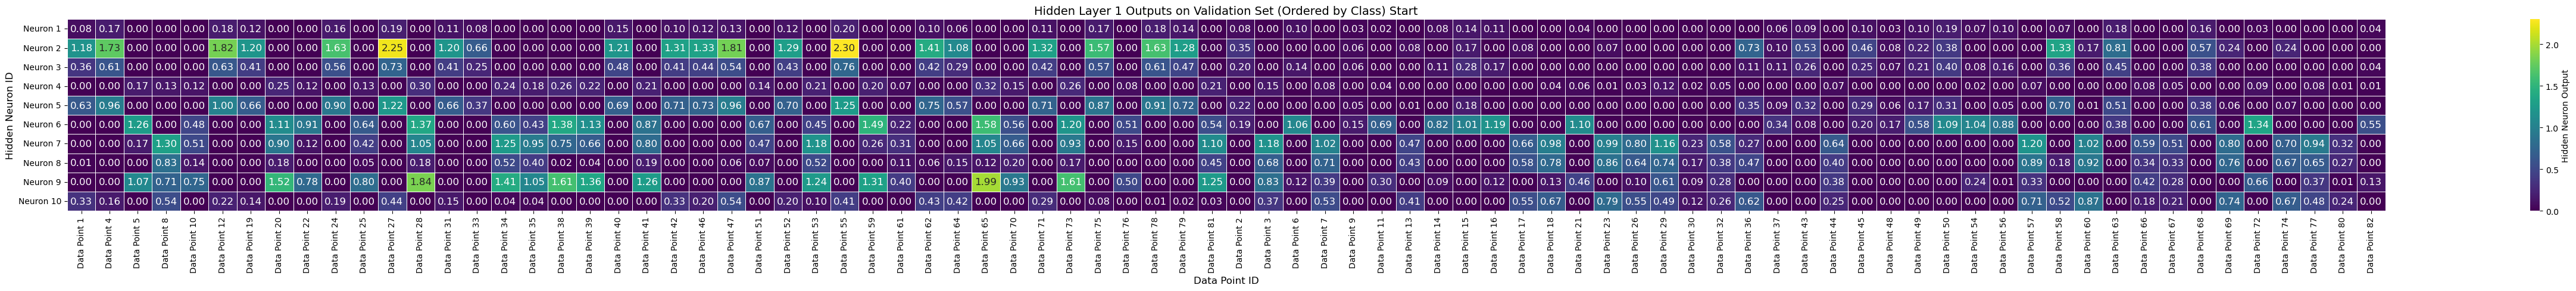

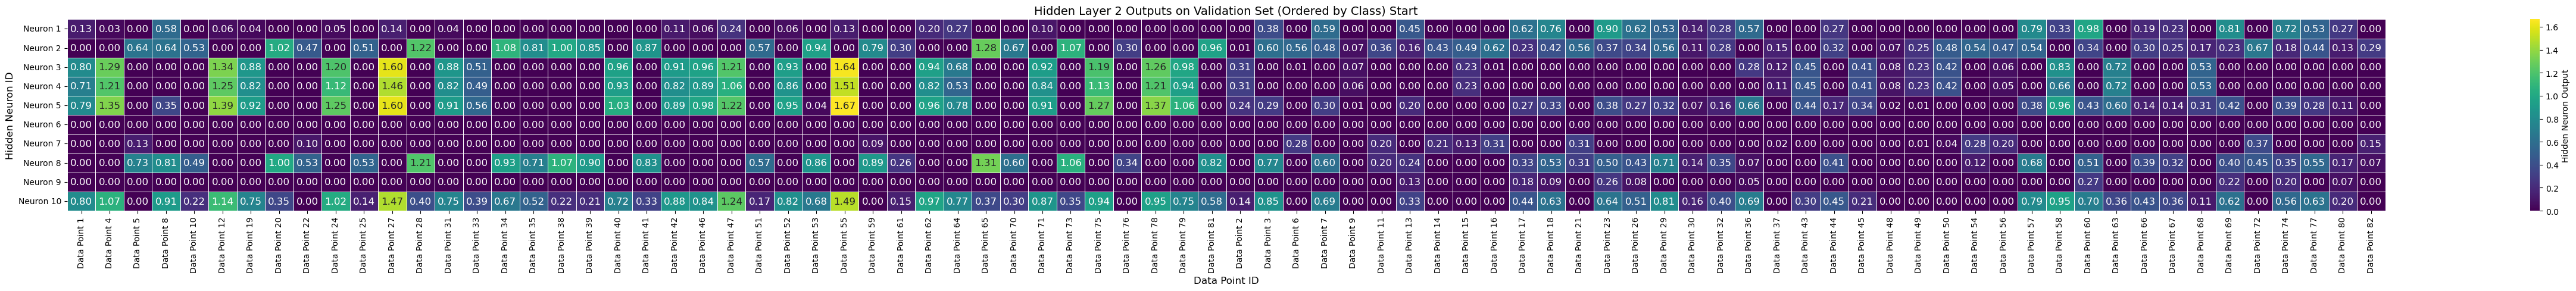

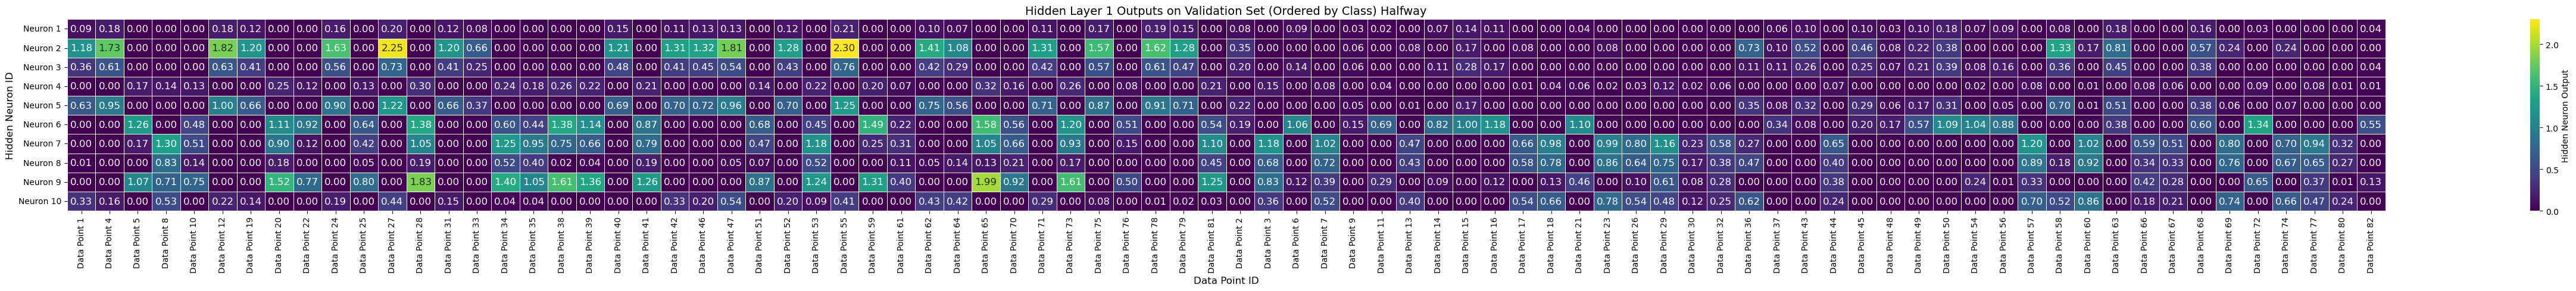

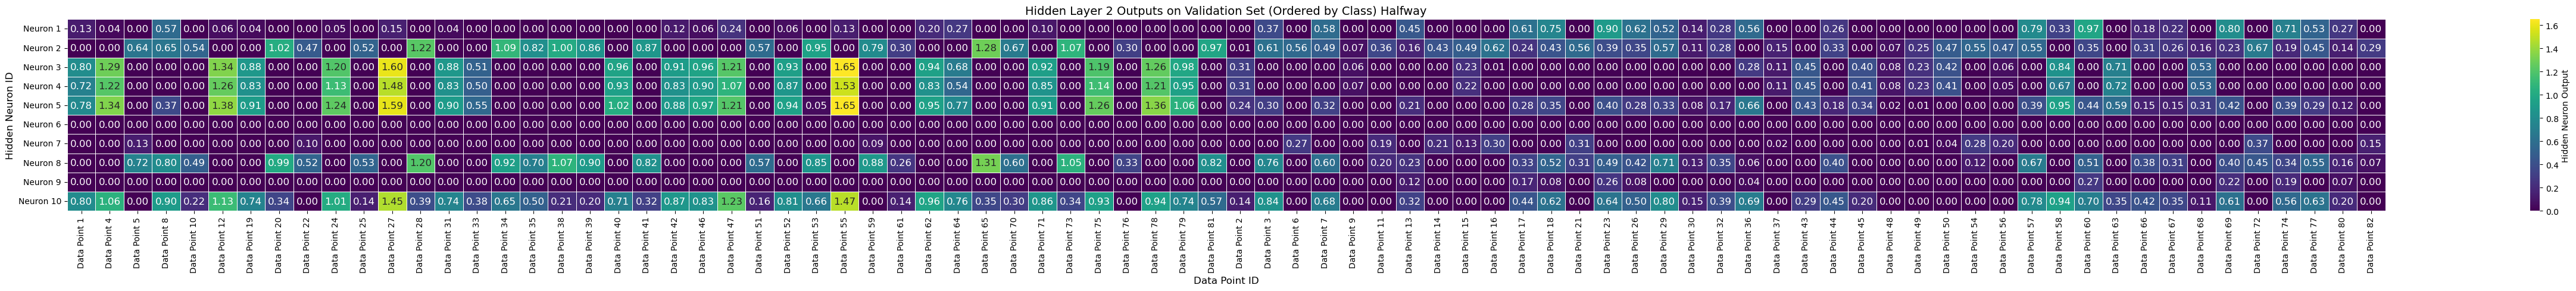

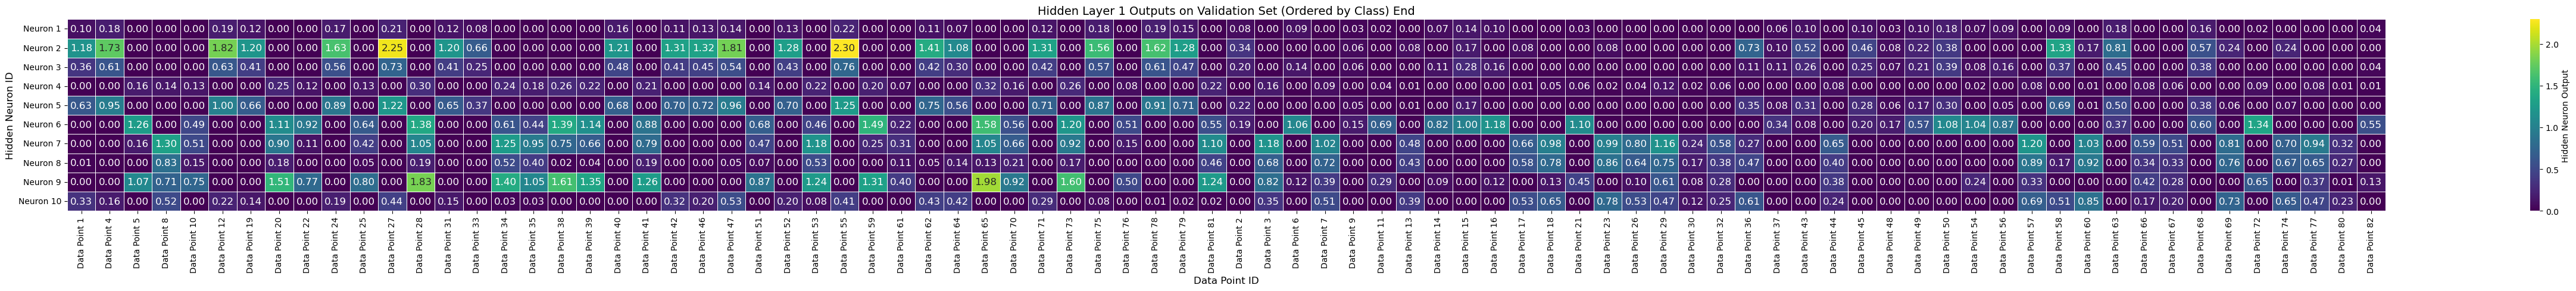

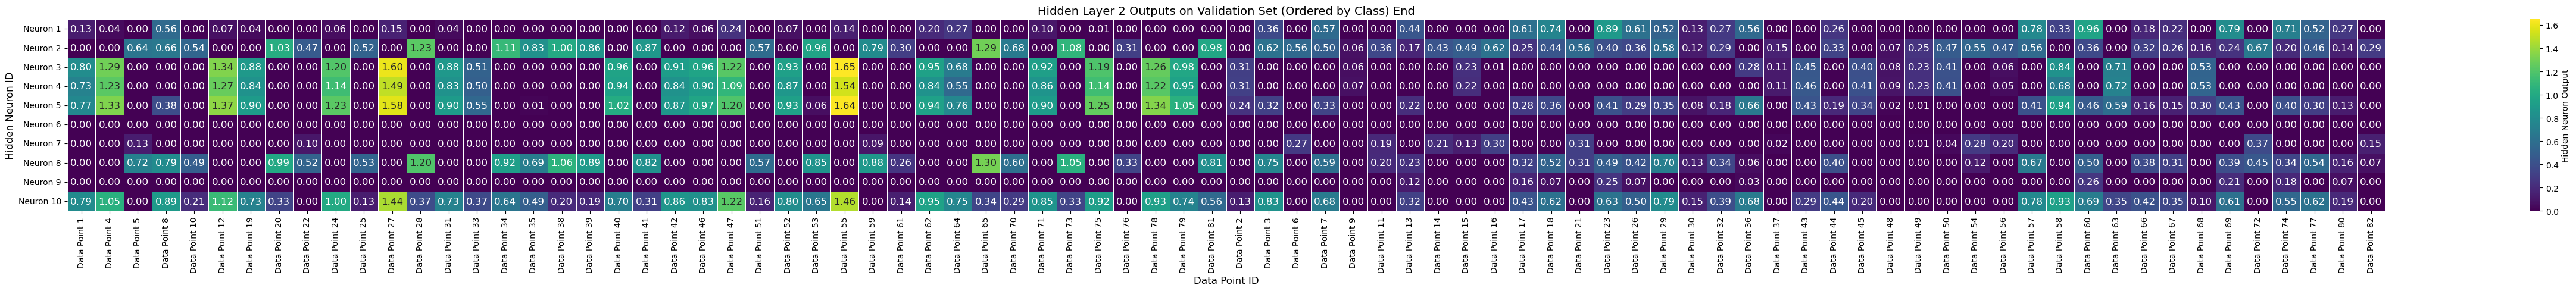

Learning rate: 1e-06, Sigma: 0.4 -------------------> Validation Accuracy: 0.304878


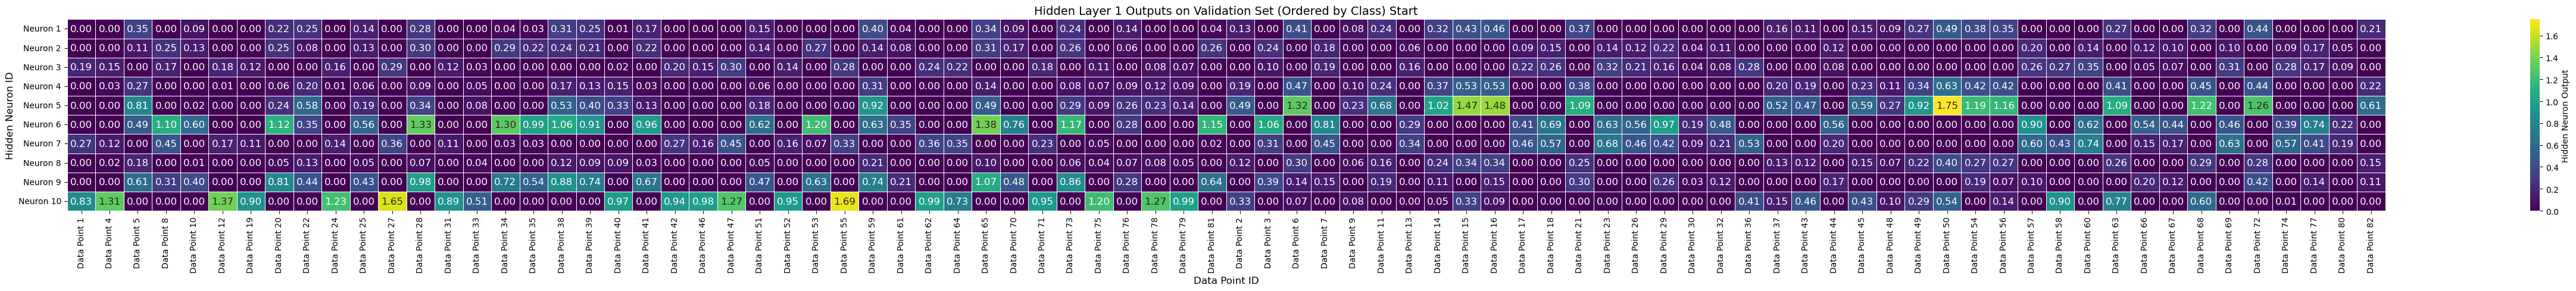

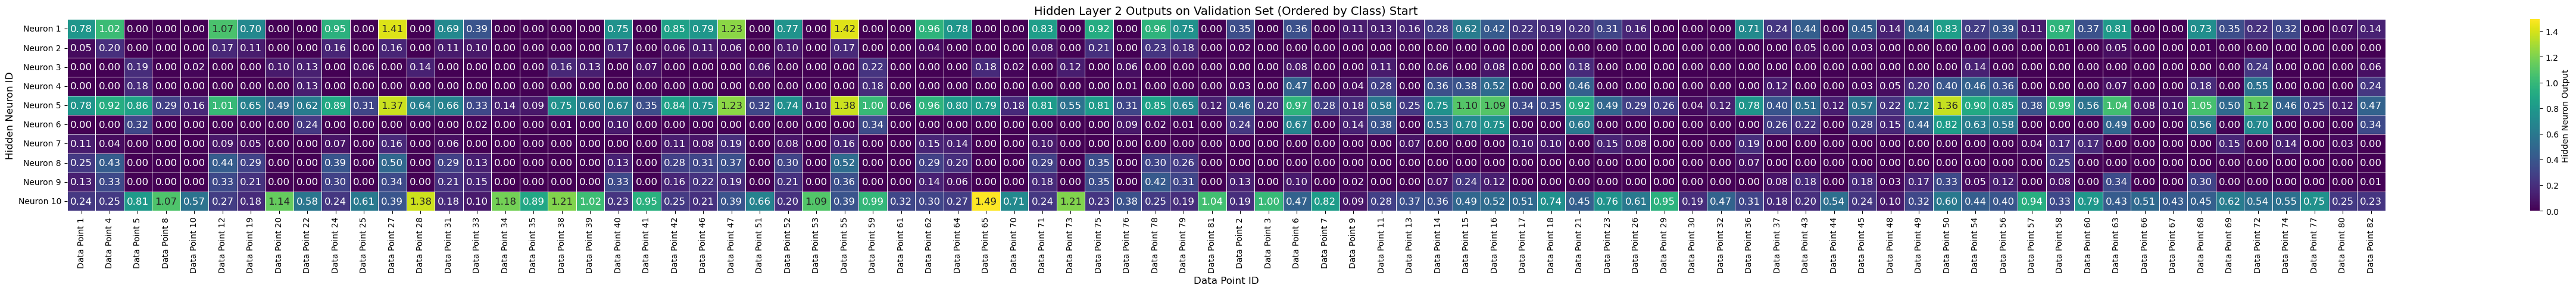

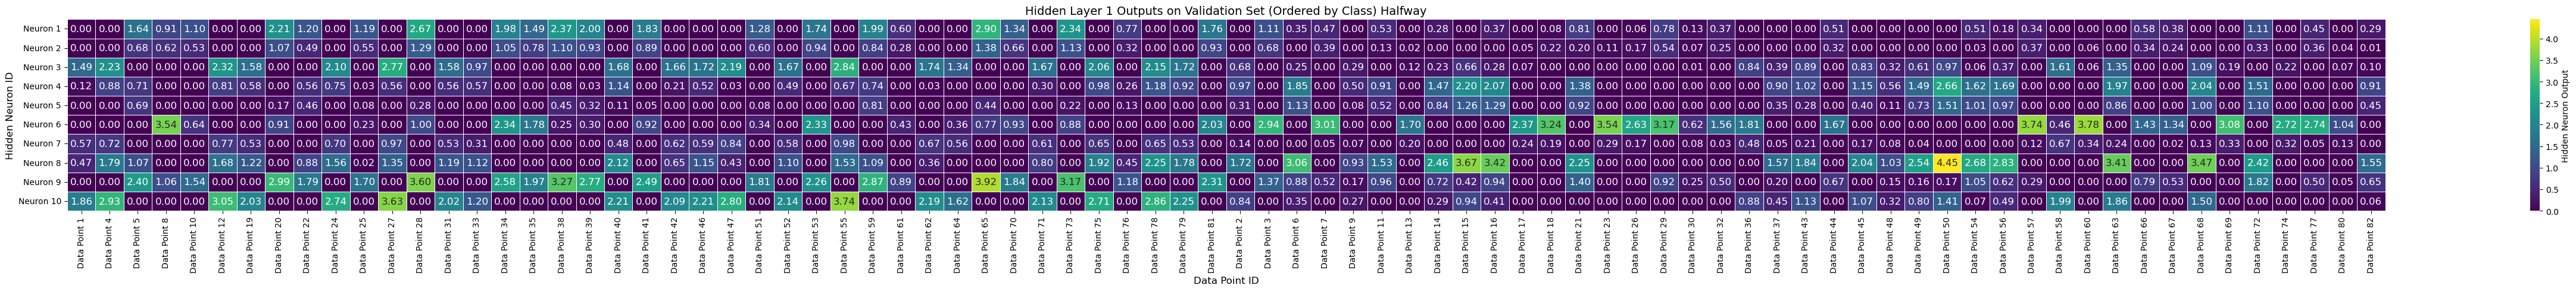

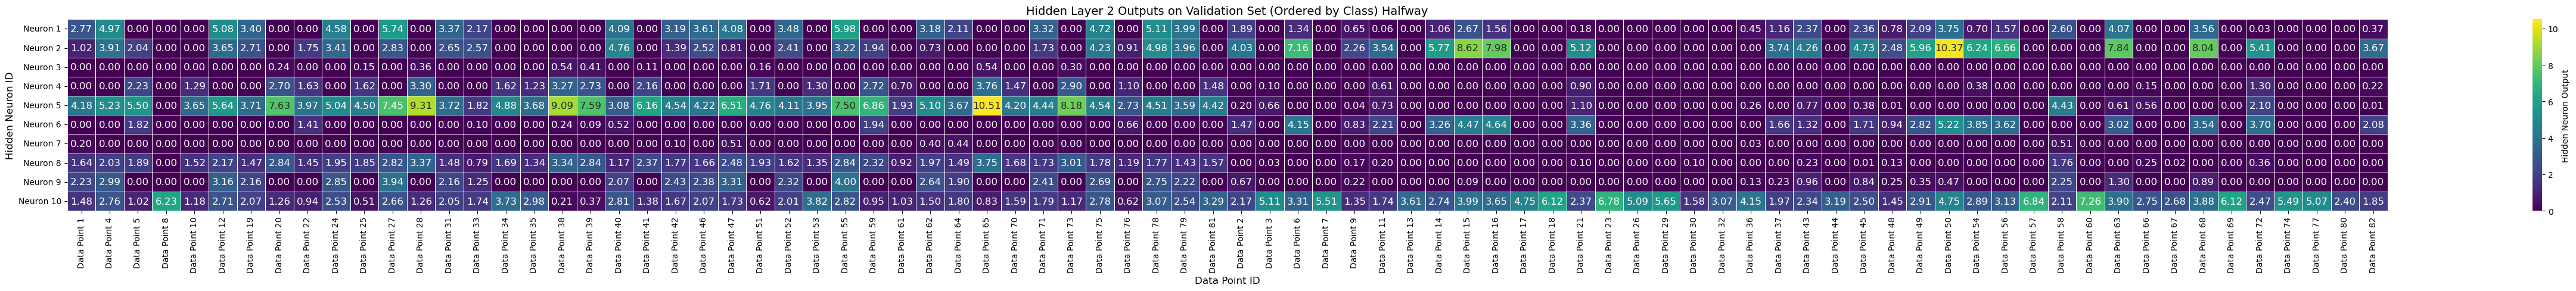

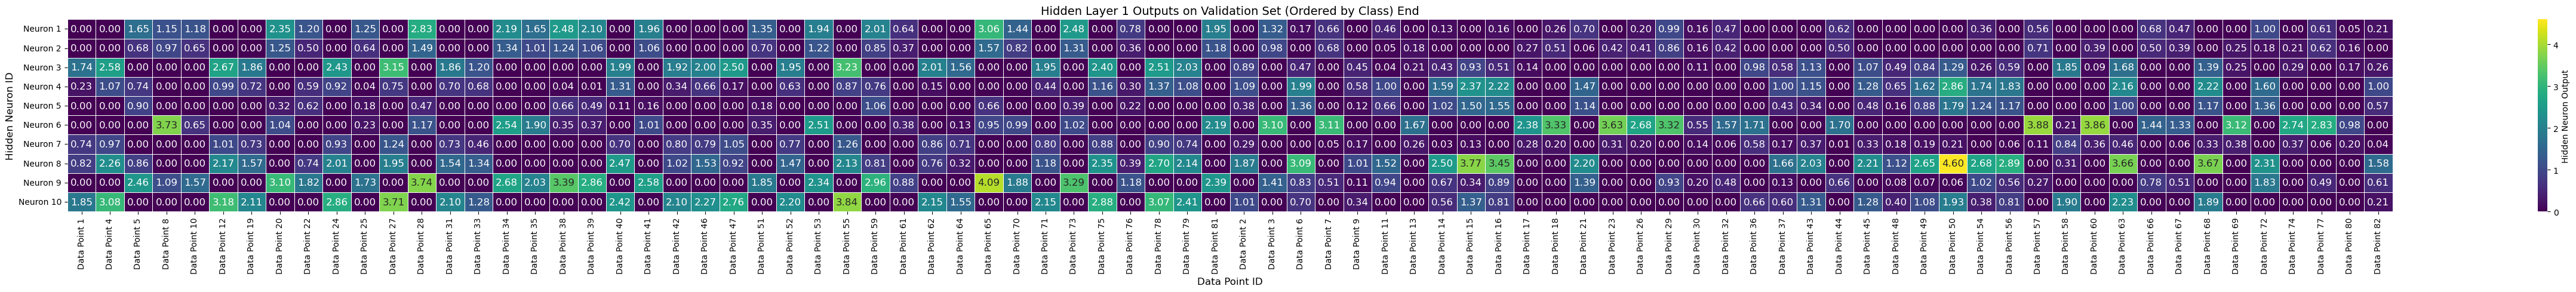

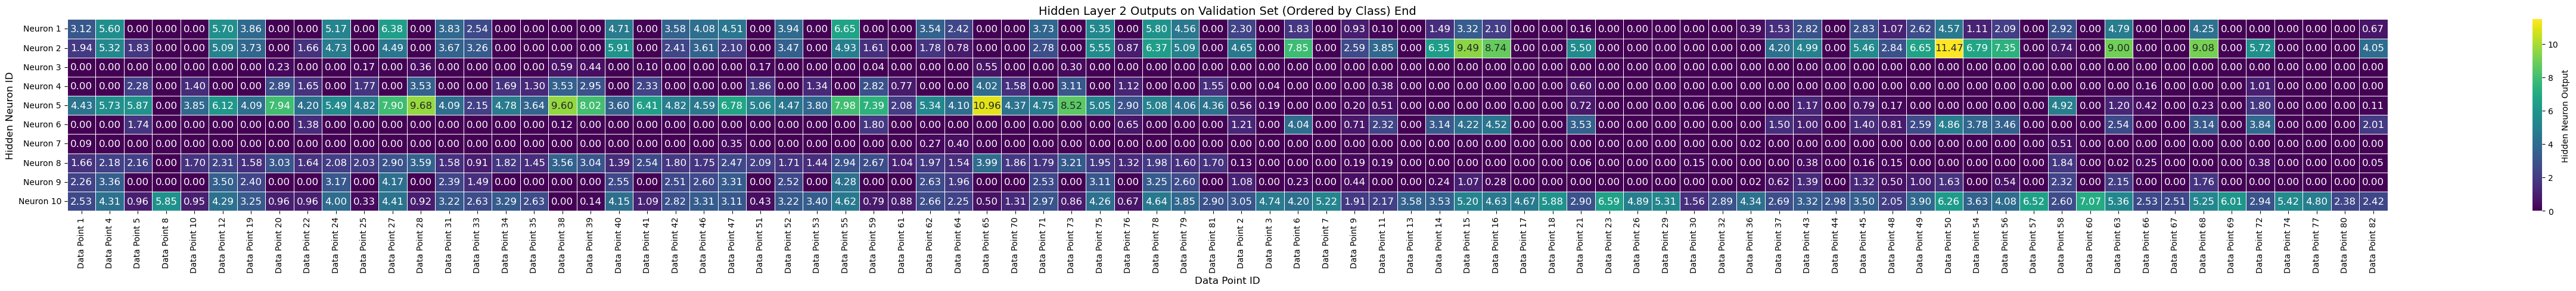

Learning rate: 0.001, Sigma: 0.4 -------------------> Validation Accuracy: 0.975610


In [161]:
mlp1 = MLP()
mlp1.model(X_train, y_train, X_val, y_val, epochs=300, retrain= 11)